In [50]:

import tensorflow as tf
import pandas as ad
import os 
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [104]:
import numpy as np
from skimage import measure
import cv2
import pandas as ad
import os

def get_coord(mask, image):
    # Find contours in the mask
    contours = measure.find_contours(mask.reshape((512, 512)), 0.85)

    # Set default values
    c = None
    diameter = None

    # Loop through the contours and extract the circle properties
    for cnt in contours:
        # Convert the contour to integer format
        cnt = np.array(cnt, dtype=np.float32)

        # Fit a circle to the contour using the minimum enclosing circle method
        (y, x), radius = cv2.minEnclosingCircle(cnt)
        
        diameter = radius * 2

        # Print the circle properties
        if x is not None and y is not None:
            c = image.TransformContinuousIndexToPhysicalPoint((x, y))
            pixel_size = image.GetSpacing()[0]
            diameter *= pixel_size
            return c, diameter
            
        else:
            print("not")
            return None, None

In [105]:
def real_cord(im,file):

        df = ad.read_csv("D:/fin_de_etude/data/pfe/data preprocessing/annotation_2.csv")
        if float(file[:-4]) in df["seriesuid"].tolist():
                df_2 = df[df["seriesuid"]==float(file[:-4])]
                for i in df_2.index:
                        x,y,d = df_2.loc[i,"coordX"],df_2.loc[i,"coordY"],df_2.loc[i,"diameter_mm"]
                        
                        pixcel = im.GetSpacing()
                        d = d*pixcel[0]
                        c = im.TransformContinuousIndexToPhysicalPoint((x, y))
                        
                                
                        return c,d
        else:
                return (None,None)

In [149]:
import tensorflow as tf
def prediction(images,files):
    c_pred = []
    d_pred = []
    c_true = []
    d_true = []
    y_2=[]
    deeplab = tf.keras.models.load_model("deeplabv3plus.h5",compile=False)
    for  image,file in zip(images,files):
                arr_2d = sitk.GetArrayFromImage(image)

                arr_2d = arr_2d/255
                mask = deeplab.predict(arr_2d.reshape((1,512,512,1)))
                mask = np.where(mask>0.5,0,1)
                circle = get_coord(mask,image)
                
                if circle is not None :
                    y_2.append(1)
                    cen, dia = real_cord(image,file)
                    if dia is not None:
                        d_pred.append(circle[1])
                        c_pred.append(circle[0])
                        c_true.append(cen)
                        d_true.append(dia)
                       
                else:
                    y_2.append(0)
                
                    
                            
                        
    return np.array(y_2),d_pred,c_pred,d_true,c_true

                        

In [150]:
def get_images(path):
    images = []
    files = []
    for file in os.listdir(path):
        if file.endswith(".mhd"):
            im = sitk.ReadImage(os.path.join(path,file))
            images.append(im)
            files.append(file)
    return images,files

In [151]:
images_pos,files_pos = get_images("D:/fin_de_etude/data/dataset_2d/nodule/")
images_neg,files_neg = get_images("D:/fin_de_etude/data/dataset_2d/nonnodule/")

In [152]:

y1 = np.ones(len(images_pos))
y2 = np.zeros(len(images_neg))
y_true = np.concatenate((y1,y2))

In [153]:
images_pos.extend(images_neg)
files_pos.extend(files_neg)


In [154]:
print(len(images_pos))

1440


In [155]:
y_pred,d_perd,c_perd ,d_true,c_true= prediction(images_pos,files_pos)


1/1 [==============================] - 0s 43ms/step


In [156]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
print(accuracy_score(y_true,y_pred))
print(precision_score(y_true,y_pred))
print(recall_score(y_true,y_pred))
print(confusion_matrix(y_true,y_pred))

0.9465277777777777
0.9846846846846847
0.9479618386816999
[[ 270   17]
 [  60 1093]]


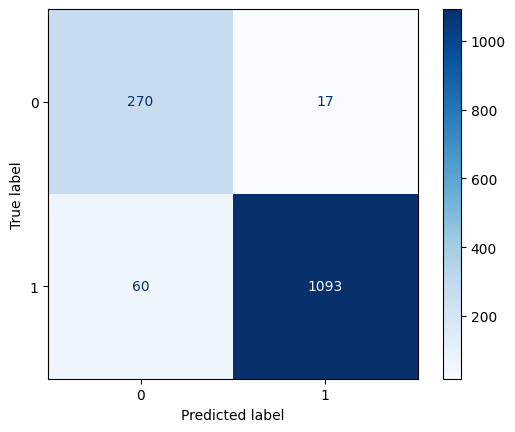

In [157]:
from sklearn.metrics import ConfusionMatrixDisplay
dis = ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred))
dis.plot(cmap=plt.cm.Blues)

In [165]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
print(mean_absolute_error(d_true,d_perd))

1.791551592048331


In [167]:
print(mean_absolute_error(c_true,c_perd,multioutput="raw_values"))

[5.54065247 3.3881546 ]
